# Filter of extreme values: Gulf Stream example

This notebook contains the code used to obtain the plots of the Chapter 2 of the report [MLD project](https://www.overleaf.com/read/rmjfbdbbrsbf) where is discussed the spurious MLD values given by ARMOR 3D in the Gulf Stream region.

The structure is the following:

    1. List of imported modules
    2. Set of dictionaries
    3. List of funcions used
    4. Plots: Original ARMOR & new ARMOR
        4.1 Comparisson of large standard deviation clusters
        4.2 Example of one grid point
        4.3 Implementation of filter and grid loss

## 1. List of imported modules

In [1]:
#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################

import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

## This module disable the print of warnings in the notebook
import warnings; warnings.simplefilter('ignore')

## 2. Dictionaries

In [2]:
"""
subregions is a dictionary that has the coordinate
boundaries of the sub-regions. The format is:
<subregion> :
  <lon> : (lon1, lon2)
  <lat> : (lat1,  lat2)
  <name> : title for an eventual ploting title
"""

subregions = {
    'lab': {
        'lon' : (-55, -51),
        'lat' : (56, 59),
        'name' : 'Labrador Sea'
    },
    'irm': {
        'lon' : (-39, -35),
        'lat' : (58, 61),
        'name' : 'Irminger Sea'
    },
    'gul': {
        'lon' : (-57, -53),
        'lat' : (34, 38),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-20, -16),
        'lat' : (50, 53),
        'name' : 'North East Sea'
    },
    'nor1': {
        'lon' : (-2, 2),
        'lat' : (73, 76),
        'name' : 'Nordic Sea- Northern'
    },
    'nor2': {
        'lon' : (0, 4),
        'lat' : (68, 71),
        'name' : 'Nordic Sea- Southern'
    }   
}


"""
reg_ext is a dictionary that has the coordinate
boundaries of the main regions. The format is:
<region> :
  <lon> : (lon1, lon2)
  <lat> : (lat1,  lat2)
  <name> : title for an eventual ploting title
"""

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-25, 20),
        'lat' : (65, 80),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 50.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}


## 3. Functions

In [42]:
def Grid(data_set):
    """Grid is a function that creates a rectangular grid using as x a longitude
    array and for y a latitude array.

    Parameters:
    ------------

    data_set : DataArray
        Is the dataset from which we will plot the histogram.

    Output:
    -------
    (x, y) : n-arrays
        Arrays that correspond for each (lon,lat) point
    """
    
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def Crops(data_set, dic,  reg_name):
    """Crops is a function that takes a data set and crops it into smaller
    region, using as parameters the values given by a variable dictionary.

    Parameters:
    ------------
    data_set : DataArray
        Dataset to be cropped
        
    dic : string
        Dictionary name.

    coord : string
        Name of the key argument for the region in the dictionary


    Output:
    -------
    new_ds : DataArray
        New data array corresponding to the region stated by 'coord'
    """
    
    
    lon1, lon2 = dic[reg_name]['lon']
    lat1, lat2 = dic[reg_name]['lat']
    name_fig = dic[reg_name]['name']
    
    
    new_ds = data_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))

    return(new_ds)


def Histogram(data_set, n_bins, xlims=None, ylims=None, i=None, ax=None, alpha=0.85, 
              htype='bar', label=None, normed=None, lw=None):
    """Histogram is a function that helps to make a semi-log histogram plot
    of a dataset. The 'y' axis is logaritmic, and the 'x' axis is linear.
    The function accepts a dataset with any kind of values and it filters the
    nan values.

    Parameters:
    ------------

    data_set : DataArray
        Is the dataset from which we will plot the histogram.

    n_bins : integer
        Number of bins for the histogram.

    xlims : tuple, float
        The limits for the x axis

    ylims : tuple, float
        The limits for the y axis

    i : integer
        Is the time step we are working on. if None, it returns the
        complete array's histogram

    ax : axes.Axes object or array of Axes objects
        axes of the n-th sub plot

    Output:
    -------
        Plot, Fig.
    """
    ## Creation of an array to save all values for the histogram
    ### This could be done in a faster way!!
    
    a = []
    
    if i == None:
        for j in range(len(data_set[:])):
            a = np.append(a, data_set[j])
    else:
        for j in range(len(data_set[i])):
            a = np.append(a, data_set[i, j])

    ##Taking away the nan values
    a2 = No_nan(a)
    ran = (xlims)
        
    if not ax:
        ax = plt.gca()
    
    N, bins, patches = ax.hist(a2, n_bins, range=ran, histtype=htype, 
                               label=label, alpha=alpha, normed=normed, linewidth=lw)
    ax.set_yscale("log", nonposy='clip')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel('MLD (m)', fontsize=10)
    ax.set_ylabel('# of occuped grid points', fontsize=10)
    ax.grid(True)
    
    return(N, bins, patches)
    
    
    
def No_nan(a):
    """No_nan is a function that helps to filter an array from nan values.
        
    Parameters:
    ------------
    a : Numpy Array
        Is the array we want to filter

    Output:
    -------
    a2 : Numpy Arrray
        Array with no nan values in it
    """
    
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Masking(data_set, cond):
    """Maskin is a function that makes a mask of an array depending on the 
    entering condition. The condition is evaluated over finite numbers.
    At the final, the mask is appended in the original DataArray as a 
    new coordinate.

    Parameters:
    ------------
    data_set : DataArray
        Is the array we want to make the mask of.

    cond : array
        Codition to meet. 


    Output:
    -------
    data_set : Numpy Arrray
        Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

In [33]:
def Year_sel(data_set, yr):
    """
        Year_sel slects an specific year from a dataset.  
        
        Parameters:
        ------------
            
        data_set : DataArray
            Array from we extract the year.
        
        yr : int
            Number of the year we want 
        
        Output:
        ------------
        y : dataArray
            DataArray containing only the data corresponding to yr
            
    """
    cond = data_set.time.dt.year.isin([yr])
    y = data_set.sel(time=cond)
    
    return(y)


def Point_sel(data_set, lon, lat, isel=True):
    """Point_sel selects a point given the latitude and longitude, or the 
    index of the array. The default function is using isel. If sel() wants
    to be used, the nearest method is used to select the point.


    Parameters:
    ------------

    data_set : DataArray
        Array from we extract the year.

    lon : float
        Coordinate for longitude.

    lat : float
        Coordinate for latitude.

    Output:
    ------------
    p : dataArray
        DataArray containing only the data corresponding to (lon, lat)
            
    """
    
    if isel:
        p = data_set.isel(longitude=lon, latitude=lat)
    else:
        p = data_set.sel(longitude=lon, latitude=lat, method='nearest')
    
    return(p)
  
    


In [34]:
def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines.

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



## Need to make this a little bit more general, also in the extend. by now extends just to max
def Plot_2D(data_set, reg, *cm_levs, t=None, cmap=None, ext=None, cont_line=False, nlines=None):
    """ Plot_2D is a function that plots a 2D variable using a
    colormap over a spatial region. It makes use of the external 
    functions 'Grid' and 'Map'. It also makes use of the dictionary 
    'reg_ext', to get the spatial delimitations. This works only
    for DataArray type and to plot MLD. The pre-defined cmap is 
    'magma_r'.

    Parameters:
    ------------
    data_set : DataArray
        Current axes object in which is drawn the map. It can
        be a complete DataArray, or just the values for one of
        the variables.

    reg : string
        Abreviation name that identifies the region in 
        which the plot is being done. It must be defined
        inside the dictionary 'reg_ext'.

    cm_levs : tuple, integers
        It contains the parameters for the color bar. The 
        order is: minimum, maximum, #of levels

    t : integer
        Timestep to plot.

    cmap : String
        Name of the color map to use. Default is 'magma_r'

    ext : string
        Extention of the color bar. Default is 'max'

    cont_line : Boolean
        If True we allow to plot a second contour plot of SSH. 
        On top of the MLD heat map.
        If False, this function plots a heat map of the variable 
        set by parameter 'data_set'.

    nlines : integers
        Is the number of lines to plot the contour plot. It is 
        optional, and is necessary when cont_line=True.

    Output:
    ------------
    ax : axes
    """
    
    # Shaping the plot
    x_n, y_n = Grid(data_set)
    projection = ccrs.PlateCarree(360)
    
    # Getting the delimitations and ticks
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtick = np.linspace(lon1, lon2, num=9)
    ytick = np.linspace(lat1, lat2, num=4)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    # If we want to plot MLD and SSH, or other thing, without SSH countours
    if cont_line:
        if not t:
            variable1 = data_set.mlotst
            variable2 = data_set.zo[0]
        else:
            variable1 = data_set.mlotst[t]
            variable2 = data_set.zo[t,0]
    else:
        if not t:
            variable1 = data_set
        else:
            variable1 = data_set[t]
        
    if not cmap:
        cmap = 'plasma_r'
        
    
    if ext:
        ext = ext
    else:
        ext = 'max'

    # Start of the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtick, ytick)
    
    # Here plot the variable using a heat map, defining also color bar
    contr1 = ax.contourf(x_n, y_n, variable1, 
                         levels=np.linspace(cm_levs[0], cm_levs[1], cm_levs[2]),
                         cmap=cmap, extend=ext)
    cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                        label='MLD [m]', extend=ext)  
    # Here adding an extra layer of SSH at surface using countour lines
    if cont_line:
        contr2 = ax.contour(x_n, y_n, variable2, nlines, linewidths=0.5, colors='k')
    
    # Saving the figure
    ##if save:
    ##    fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))

    return(ax)
    
    
def Limits(data_set):
    
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    return(mn, mx)
    

In [6]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################


## Opening the datasets    
### it is pending to change the directory for ARMOR!!
dir_1 = '../../New_ARMOR/'
dir_15 = '/net/krypton/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'

c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')

c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)
c_armor15 = Masking(c_armor15, c_armor15.to[0,25])

In [7]:
d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

# Let's see the Gulf Stream: Mean and Standard deviation

In [43]:
#Crops(d_set, lon1=None, lon2=None, lat1=None, lat2=None, reg_name=None, dic=None):
reg = 'gul'
gulf = Crops(c_armor15, reg_ext, reg)

<IPython.core.display.Javascript object>


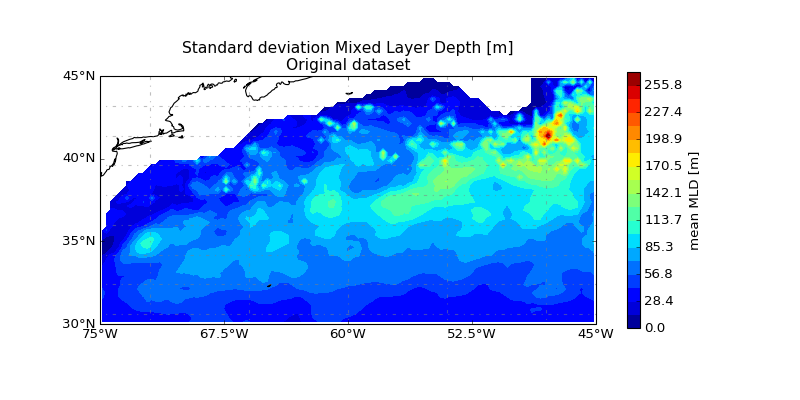

In [44]:
%matplotlib notebook

plt.close()

lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
xtik = np.linspace(lon1, lon2, num=5)
ytik = np.linspace(lat1, lat2, num=4)

x_n, y_n = Grid(gulf)

projection = ccrs.PlateCarree(360)
region = [lon1, lon2, lat1, lat2]    #Lon, Lat

# Variables to plot
mapping_var = gulf.mlotst.where(gulf.mask == 1).std(dim='time')   # In the colormap
#contour_var = stdv1.mlotst.where(gulf15.mask == 1)    # Variable to plot in lines

cb_label = 'mean MLD [m]'    # Label for colorbar
cmap = 'jet'
levels = np.linspace(0., 270., 20)
n_lines = 11


## Title for the figure
fig_title = 'Standard deviation Mixed Layer Depth [m]\nOriginal dataset'  

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), 
                        figsize=(10,5)) 

Map(ax, region, xtik, ytik)

contr1 = ax.contourf(x_n, y_n, mapping_var, levels=levels, cmap=cmap, extend='neither')

cbar = fig.colorbar(contr1, ax=ax, shrink=0.8, orientation='vertical',
                    label=cb_label) 

ax.set_title(fig_title, fontsize=14)


#plt.savefig(dir_o + 'Gul-std_O.png', bbox_inches='tight')
plt.show()

In [10]:
#Crops(d_set, lon1=None, lon2=None, lat1=None, lat2=None, reg_name=None, dic=None):
gulf1 = Crops(reg, c_armor1)

<IPython.core.display.Javascript object>


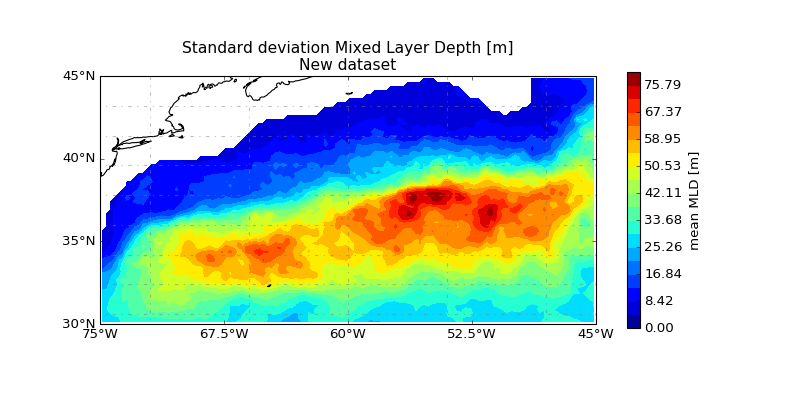

In [13]:
%matplotlib notebook

plt.close()

lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
xtik = np.linspace(lon1, lon2, num=5)
ytik = np.linspace(lat1, lat2, num=4)

x_n, y_n = Grid(gulf)

projection = ccrs.PlateCarree(360)
region = [lon1, lon2, lat1, lat2]    #Lon, Lat

# Variables to plot
mapping_var = gulf1.mlotst.where(gulf.mask == 1).std(dim='time')   # In the colormap
#contour_var = stdv1.mlotst.where(gulf15.mask == 1)    # Variable to plot in lines

cb_label = 'mean MLD [m]'    # Label for colorbar
cmap = 'jet'
levels = np.linspace(0., 80., 20)
n_lines = 11


## Title for the figure
fig_title = 'Standard deviation Mixed Layer Depth [m]\nNew dataset'  

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), 
                        figsize=(10,5)) 

Map(ax, region, xtik, ytik)

contr1 = ax.contourf(x_n, y_n, mapping_var, levels=levels, cmap=cmap, extend='neither')

cbar = fig.colorbar(contr1, ax=ax, shrink=0.8, orientation='vertical',
                    label=cb_label) 

#contr2 = ax.contour(x_n, y_n, contour_var, n_lines, linewidths=1, colors='k')


#cbar.set_clim(vmin=0., vmax=300.)
#ax.clabel(contr2, fontsize=8, inline=10)
ax.set_title(fig_title, fontsize=14)

#plt.savefig(dir_o + 'Gul-std_N.png', bbox_inches='tight')
plt.show()

In [14]:
def Season(month, m1, m2):
    return (month >= m1) & (month <= m2)

In [15]:
JFM = gulf.sel(time=Season(gulf['time.month'], 1, 3))
JFM_mn = JFM.mlotst.mean(dim='time', skipna=True)
JFM_st = JFM.mlotst.std(dim='time', skipna=True)

print(JFM_mn.sel(longitude=-47.875, latitude=41.375).values, 
      JFM_st.sel(longitude=-47.875, latitude=41.375).values)

182.96756 530.75146


<IPython.core.display.Javascript object>


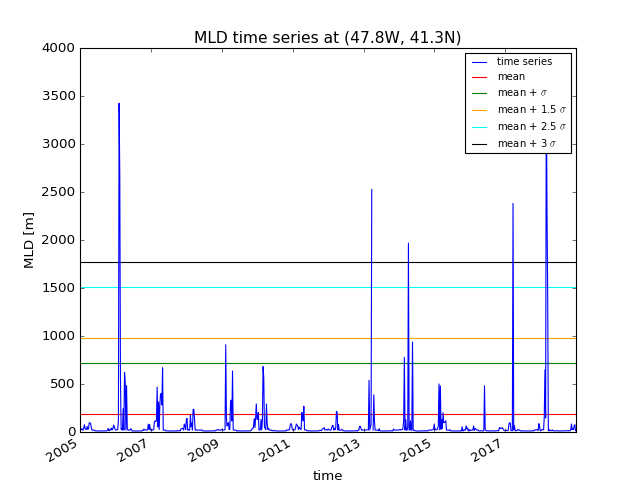

In [21]:
c0 = JFM_mn + 1.0 * JFM_st
c1 = JFM_mn + 1.5 * JFM_st
c2 = JFM_mn + 2.5 * JFM_st
c3 = JFM_mn + 3.0 * JFM_st



plt.close()
gulf.mlotst.sel(longitude=-47.875, latitude=41.375).plot(label='time series')

plt.hlines(JFM_mn.sel(longitude=-47.875, latitude=41.375), 
           '01-01-2005', '31-12-2018', color='red', label='mean')

plt.hlines(c0.sel(longitude=-47.875, latitude=41.375), 
           '01-01-2005', '31-12-2018', color='green', label='mean + $\sigma$')

plt.hlines(c1.sel(longitude=-47.875, latitude=41.375), 
           '01-01-2005', '31-12-2018', color='orange', label='mean + 1.5 $\sigma$')

plt.hlines(c2.sel(longitude=-47.875, latitude=41.375), 
           '01-01-2005', '31-12-2018', color='cyan', label='mean + 2.5 $\sigma$')

plt.hlines(c3.sel(longitude=-47.875, latitude=41.375), 
           '01-01-2005', '31-12-2018', label='mean + 3 $\sigma$')

plt.ylabel('MLD [m]')
plt.legend(fontsize=9)

plt.title('MLD time series at (47.8W, 41.3N)', fontsize=14)

#plt.savefig(dir_o + 'STD_O.png', bbox_inches='tight')
plt.show()

## Filtering:

### Using  MLD >=  mean +2.5 $\sigma$

Lets say that I want to get rid of the values that are MLD >= 2.5 $\sigma$

In [17]:
#c1 = JFM_mn + 1.5 * JFM_st
c2 = JFM_mn + 2.5 * JFM_st

In [24]:
new1 = gulf.where(gulf.mlotst <= c2)

<IPython.core.display.Javascript object>


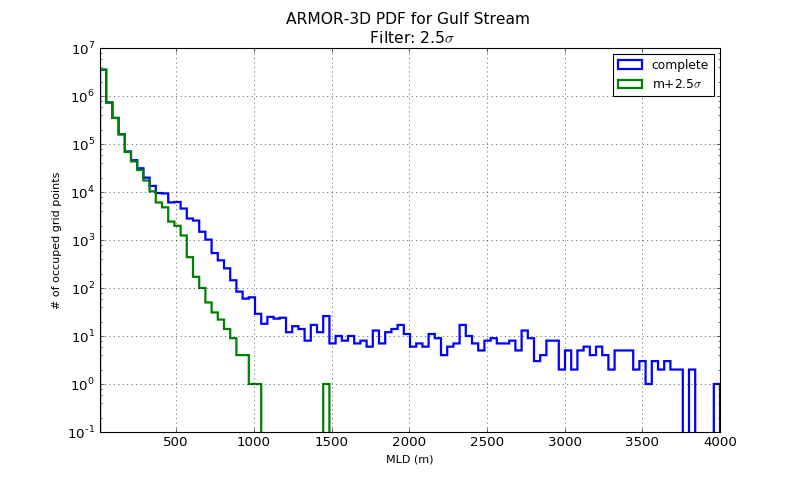

In [25]:

xlims_g = 10, 4000
ylims_g = 10e-2, 10e6


plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), sharey=True)

N_o, bins_o, patches_o = Histogram(gulf.mlotst, 100, xlims_g, ylims_g, 
                             None, ax, 1., 'step', 'complete', lw=2)

N, bins, patches = Histogram(new1.mlotst, 100, xlims_g, ylims_g, None, 
                             ax, 1., 'step', 'm+2.5$\sigma$', lw=2)
ax.set_title('ARMOR-3D PDF for Gulf Stream \n Filter: 2.5$\sigma$', fontsize=14)

plt.legend(fontsize=11)
#plt.savefig('/home/lgarcia/Documents/Scripts/Images/Gul-PDF-comp.png')
plt.show()

<IPython.core.display.Javascript object>


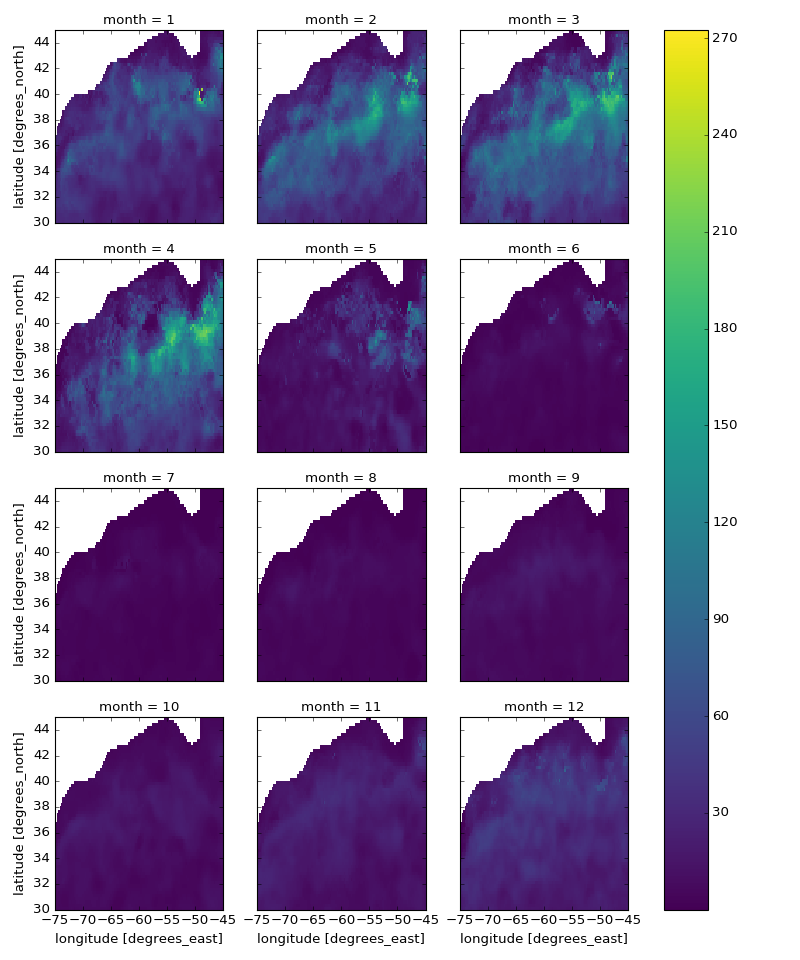

In [45]:
plt.close()
new1.mlotst.where(new1.mask==1).groupby(
    'time.month').std(dim='time').plot(col='month', col_wrap=3, robust=False)

<IPython.core.display.Javascript object>


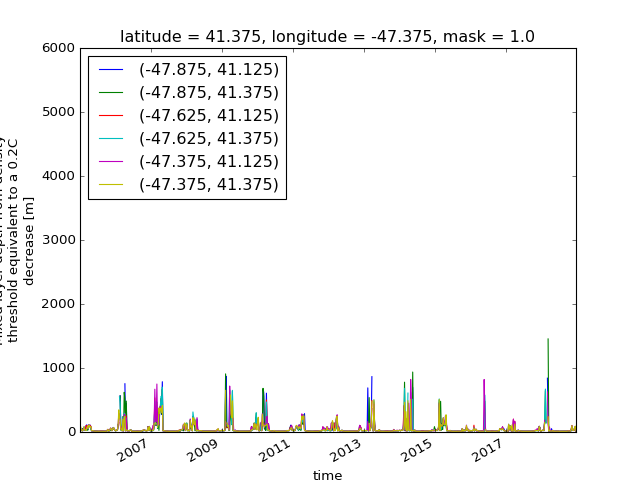

In [46]:
small = new1.mlotst.sel(longitude=slice(-48, -47.2), latitude=slice(41., 41.6))
small.latitude

plt.close()
for i in range(3):
    for j in range(2):
        lo = small.longitude[i].values.max()
        la = small.latitude[j].values.max()
        small.isel(longitude=i, latitude=j).plot(label=(lo,la))
        plt.legend(loc='upper left')
        plt.ylim(0, 6000)

### Using  MLD >=  mean +3. $\sigma$

Lets say that I want to get rid of the values that are MLD >= 2.5 $\sigma$

In [47]:
c3 = JFM_mn + 3. * JFM_st

In [48]:
new3 = gulf.where(gulf.mlotst <= c3)

<IPython.core.display.Javascript object>


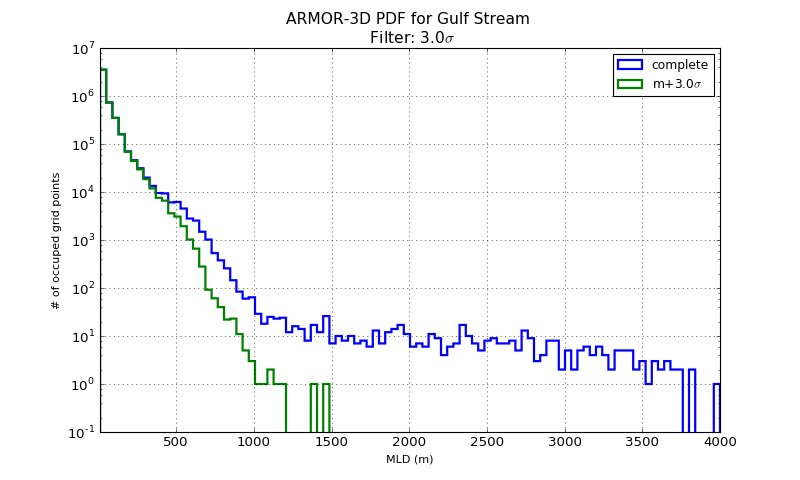

In [49]:

xlims_g = 10, 4000
ylims_g = 10e-2, 10e6


plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), sharey=True)

N_o, bins_o, patches_o  = Histogram(gulf.mlotst, 100, xlims_g, ylims_g, None, ax, 1., 'step', 
          'complete', lw=2)

N_3, bins_3, patches_3  = Histogram(new3.mlotst, 100, xlims_g, ylims_g, None, ax, 1., 'step', 
          'm+3.0$\sigma$', lw=2)
ax.set_title('ARMOR-3D PDF for Gulf Stream \n Filter: 3.0$\sigma$', fontsize=14)

plt.legend(fontsize=11)
#plt.savefig('/home/lgarcia/Documents/Scripts/Images/Gul-PDF-comp.png')
plt.show()

<IPython.core.display.Javascript object>


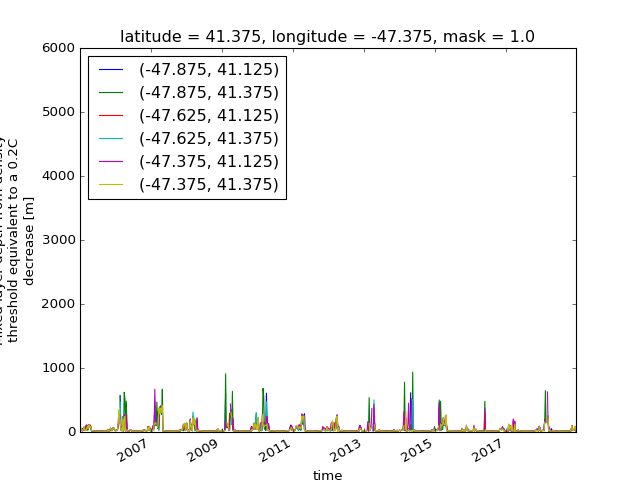

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


In [17]:
small = new3.mlotst.sel(longitude=slice(-48, -47.2), latitude=slice(41., 41.6))
small.latitude

plt.close()
for i in range(3):
    for j in range(2):
        lo = small.longitude[i].values.max()
        la = small.latitude[j].values.max()
        small.isel(longitude=i, latitude=j).plot(label=(lo,la))
        plt.legend(loc='upper left')
        plt.ylim(0, 6000)